In [1]:
!pip install vaderSentiment
!pip install textstat
!pip install matplotlib==2.0.2

In [2]:
import pickle
import numpy as np
import pandas as pd
from sklearn.externals import joblib
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.stem.porter import *
import string
import re
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Loading data to classify...
16  tweets to classify
Loading trained classifier... 
Loading other information...
Transforming inputs...
Built TF-IDF array


/usr/local/lib/python2.7/dist-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator LinearSVC from version 0.18 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.18 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.18 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/feature_extraction/text.py:1577: UserWarning: Only (<type 'numpy.float64'>, <type 'numpy.float32'>, <type 'numpy.float16'>) 'dtype' should be used. <type 'numpy.int64'> 'dtype' will be converted to n

Built POS array
Built other feature array
Running classification model...
Printing predicted values: 
Obama can kill Americans at will with drones but waterboarding is not allowed only in America!
Hate speech
26,000 unreported sexual 
assaults in the military-only 238 convictions. 
What did these geniuses expect when they put men & 
women together?
Neither
The United States will be powerfully,
supporting those industries, like Airlines and others, that
are particularly affected by the Chinese Virus. We will be 
stronger than ever before!
Neither
"@nyccoins: @DanAmira @realDonaldTrump @NYMag Dan, you are a low life dumb ass! Stupid too, who made you an editor?"  A dead magazine!
Hate speech
But whenever she sees me, she kisses my ass. She's disgusting. @BetteMidler
Offensive language
Every time I speak of the haters and losers I do so with great love and affection. They cannot help the fact that they were born fucked up!
Hate speech
@caaataclysm   Little Jon Stewart(?) Is a pussy, he wo

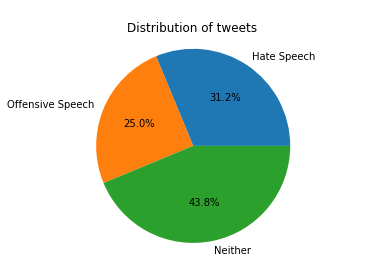


Hate Speech: 31.25
Offensive Speech: 25.0
Neither: 43.75


In [3]:
stopwords=stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

sentiment_analyzer = VS()

stemmer = PorterStemmer()


def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    #parsed_text = parsed_text.code("utf-8", errors='ignore')
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    #tokens = re.split("[^a-zA-Z]*", tweet.lower())
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

def get_pos_tags(tweets):
    """Takes a list of strings (tweets) and
    returns a list of strings of (POS tags).
    """
    tweet_tags = []
    for t in tweets:
        tokens = basic_tokenize(preprocess(t))
        tags = nltk.pos_tag(tokens)
        tag_list = [x[1] for x in tags]
        #for i in range(0, len(tokens)):
        tag_str = " ".join(tag_list)
        tweet_tags.append(tag_str)
    return tweet_tags

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE
    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features_(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features.
    This is modified to only include those features in the final
    model."""

    sentiment = sentiment_analyzer.polarity_scores(tweet)

    words = preprocess(tweet) #Get text only

    syllables = textstat.syllable_count(words) #count syllables in words
    num_chars = sum(len(w) for w in words) #num chars in words
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))

    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)

    twitter_objs = count_twitter_objs(tweet) #Count #, @, and http://
    features = [FKRA, FRE, syllables, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['compound'],
                twitter_objs[2], twitter_objs[1],]
    #features = pandas.DataFrame(features)
    return features

def get_oth_features(tweets):
    """Takes a list of tweets, generates features for
    each tweet, and returns a numpy array of tweet x features"""
    feats=[]
    for t in tweets:
        feats.append(other_features_(t))
    return np.array(feats)


def transform_inputs(tweets, tf_vectorizer, idf_vector, pos_vectorizer):
    """
    This function takes a list of tweets, along with used to
    transform the tweets into the format accepted by the model.
    Each tweet is decomposed into
    (a) An array of TF-IDF scores for a set of n-grams in the tweet.
    (b) An array of POS tag sequences in the tweet.
    (c) An array of features including sentiment, vocab, and readability.
    Returns a pandas dataframe where each row is the set of features
    for a tweet. The features are a subset selected using a Logistic
    Regression with L1-regularization on the training data.
    """
    tf_array = tf_vectorizer.fit_transform(tweets).toarray()
    tfidf_array = tf_array*idf_vector
    print "Built TF-IDF array"

    pos_tags = get_pos_tags(tweets)
    pos_array = pos_vectorizer.fit_transform(pos_tags).toarray()
    print "Built POS array"

    oth_array = get_oth_features(tweets)
    print "Built other feature array"

    M = np.concatenate([tfidf_array, pos_array, oth_array],axis=1)
    return pd.DataFrame(M)

def predictions(X, model):
    """
    This function calls the predict function on
    the trained model to generated a predicted y
    value for each observation.
    """
    y_preds = model.predict(X)
    return y_preds

def class_to_name(class_label):
    """
    This function can be used to map a numeric
    feature name to a particular class.
    """
    if class_label == 0:
        return "Hate speech"
    elif class_label == 1:
        return "Offensive language"
    elif class_label == 2:
        return "Neither"
    else:
        return "No label"

def get_tweets_predictions(tweets, perform_prints=True):
    fixed_tweets = []
    for i, t_orig in enumerate(tweets):
        s = t_orig
        try:
            s = s.encode("latin1")
        except:
            try:
                s = s.encode("utf-8")
            except:
                pass
        if type(s) != unicode:
            fixed_tweets.append(unicode(s, errors="ignore"))
        else:
            fixed_tweets.append(s)
    assert len(tweets) == len(fixed_tweets), "shouldn't remove any tweets"
    tweets = fixed_tweets
    print len(tweets), " tweets to classify"

    print "Loading trained classifier... "
    model = joblib.load('/content/model.pkl')

    print "Loading other information..."
    tf_vectorizer = joblib.load('/content/tfidf.pkl')
    idf_vector = joblib.load('/content/idf.pkl')
    pos_vectorizer = joblib.load('/content/pos.pkl')
    #Load ngram dict
    #Load pos dictionary
    #Load function to transform data

    print "Transforming inputs..."
    X = transform_inputs(tweets, tf_vectorizer, idf_vector, pos_vectorizer)

    print "Running classification model..."
    predicted_class = predictions(X, model)

    return predicted_class


if __name__ == '__main__':
    print "Loading data to classify..."

    df = pd.read_csv('/content/trump_tweets.csv')
    trump_tweets = df.Text
    trump_tweets = [x for x in trump_tweets if type(x) == str]
    trump_predictions = get_tweets_predictions(trump_tweets)

    print "Printing predicted values: "
    for i,t in enumerate(trump_tweets):

            print t
            print class_to_name(trump_predictions[i])
            

    #print "Calculate accuracy on labeled data"
    #df = pd.read_csv('/content/labeled_data.csv')
    #tweets = df['tweet'].values
    #tweets = [x for x in tweets if type(x) == str]
    #tweets_class = df['class'].values
    #predictions = get_tweets_predictions(tweets)

    hatespeech=0
    neither=0
    offensive=0
    for i,t in enumerate(trump_tweets):

        if class_to_name(trump_predictions[i]) == 'Hate speech':
            hatespeech += 1
        if class_to_name(trump_predictions[i]) == 'Offensive language':
            offensive += 1
        if class_to_name(trump_predictions[i]) == 'Neither':
            neither += 1
        
    #accuracy = right_count / float(len(df))
    #print "accuracy", accuracy
    a = (float(hatespeech)/len(df))*100
    b = (float(offensive)/len(df))*100
    c = (float(neither)/len(df))*100

    print '\n\n\n'
    my_data = [a,b,c]
    my_labels = 'Hate Speech','Offensive Speech','Neither'
    plt.pie(my_data,labels=my_labels,autopct='%1.1f%%')
    plt.title('\nDistribution of tweets')
    plt.axis('equal')
    plt.show()

    print '\nHate Speech:',(float(hatespeech)/len(df))*100
    print 'Offensive Speech:', (float(offensive)/len(df))*100
    print 'Neither:', (float(neither)/len(df))*100